# Fitting Joint Species Distribution Models with jsdmstan

{bdg-link-info}`Notebook Repository <https://github.com/NERC-CEH/ds-toolbox-notebook-jsdmstan.git>`
{bdg-link-info}`Method Repository <https://github.com/NERC-CEH/jsdmstan.git>`

Primary Contact: [Dr. Fiona Seaton](https://www.ceh.ac.uk/staff/fiona-seaton)


````{card} Challenge:
Modelling ecological communities involves understanding not just how individual species respond to their environment, but also how they interact with one another. Species often co-occur or exhibit similar patterns of response to environmental conditions, meaning their distributions are not independent. Traditional species distribution models, which treat each species in isolation, miss this shared structure. The challenge is to develop models that can capture these interdependencies, enabling more accurate and ecologically realistic predictions by leveraging information across multiple species simultaneously.
`````

````{card} Approach:
Joint Species Distribution Models (JSDMs) address this challenge by modelling all species in a community together. They incorporate environmental covariates, species-specific effects (like individual intercepts), and—critically—covariance between species to account for shared variation and co-occurrence patterns. This covariance can be specified either through a full multivariate model that directly estimates the species covariance matrix, or more efficiently via latent variable models (GLLVMs), which reduce dimensionality by capturing shared structure with a small number of latent factors. 

The jsdmstan R package is an interface for fitting joint species
distribution models (JSDMs) in Stan. First, we will go through an
introduction to joint species distribution models in general, followed
by examples of how to use the jsdmstan package to simulate data and fit
JSDMs to this simulated data, and finally two examples of using jsdmstan
on real ecological data.
````

# Introduction to Joint Species Distribution Models

Joint Species Distibution Models are models that model an entire
community of species simultaneously. The idea behind these is that they
allow information to be borrowed across species, such that the
covariance between species can be used to inform the predictions of
distributions of related or commonly co-occurring species.

In plain language (or as plain as I can manage) JSDMs involve the
modelling of an entire species community as a function of some
combination of intercepts, covariate data and species covariance.
Therefore the change of a single species is related to not only change
in the environment but also how it relates to other species. There are
several decisions to be made in how to specify these models - the
standard decisions on which covariates to include, whether each species
should have its own intercept (generally yes) and how to represent
change across sites - but also how to represent the covariance between
species. There are two options for representing this species covariance
in this package. First, the original way of running JSDMs was to model
the entire covariance matrix between species in a multivariate
generalised linear mixed model (MGLMM). However, more recently there
have been methods developed that involve representing the covariance
matrix with a set of linear latent variables - known as generalised
linear latent variable models (GLLVM).

The jsdmstan package aims to provide an interface for fitting these
models in [Stan](https://mc-stan.org/) using the Stan Hamiltonian Monte
Carlo sampling as a robust Bayesian methodology.

## Underlying maths

Feel free to skip this bit if you don’t want to read equations, it is
largely based on Warton et
al. ([2015](http:://doi.org/10.1016/j.tree.2015.09.007)). We model the
community data $m_{ij}$ for each site $i$ and taxon $j$ as a function of
a species intercept, environmental covariates and species covariance
matrix:

$$g(m_{ij}) = \beta_{0j} + \mathbf{x}_i^\intercal\beta_j + u_{ij}$$

where $g(\cdot)$ is the link function, $\mathbf{x}_i^\intercal$ is the
transpose of vector $\mathbf{x}$, and for each taxon $j$, $\beta_{0j}$
is an intercept and $beta_j$ is a vector of regression coefficients
related to measured predictors.

A site effect $\alpha_{i}$ can also be added to adjust for total
abundance or richness:

$$g(m_{ij}) = \alpha_{i} + \beta_{0j} + \mathbf{x}_i^\intercal\beta_j + u_{ij}$$

### Multivariate Generalised Linear Mixed Models

The entire matrix of covariance between species is modelled in MGLMMs.

$$u_{ij} \sim \mathrm{N}(\mathbf{0},\mathbf{\Sigma})$$

Fitting the entire covariance matrix means that the amount of time
required to fit these models scales with the number of species cubed,
and the data required scales with the number of species squared. This
makes these models both computationally and data intensive.

### Generalised Linear Latent Variable Models

In response to some of these issues in fitting MGLMMs, GLLVMs were
developed in which $u_{ij}$ is now specified as a linear function of a
set of latent variables $\mathbf{z_i}$:

$$y_{ij}|\mathbf{u}_i \sim \mathrm{F}(m_{ij},\phi_j)$$
$$u_{ij} = \mathbf{z}_i^\intercal \lambda_j$$

The latent variables $\mathbf{z_i}$ are treated as random by assuming:

$$y_{ij}|\mathbf{z_i} \sim \mathrm{F}(m_{ij},\phi_j)$$

$$\mathbf{z_i} \sim \mathrm{N}(\mathbf{0},\mathbf{1})$$

Treating the species covariance as pulling from a set of latent variables greatly
reduces the computational time required to fit these models.

### Relationship to environmental covariates

Within jsdmstan the response of species to environmental covariates can
either be unstructured (the default) or constrained by a covariance
matrix between the environmental covariates. This second option
(specified by setting `beta_param = "cor"`) assumes that if one species
is strongly positively related to multiple covariates then it is more
likely that other species will either also be positively related to all
these covariates, or negatively related. Mathematically this corresponds
to:

$$\beta_j \sim \mathrm{N}(\mathbf{0},\mathbf{\Sigma})$$

# Examples with Simulated Data

First, we’ll load in the R packages we’ll be using here. The jsdmstan
package can be installed from github using the remotes package.

In [ ]:
# remotes::install_github("NERC-CEH/jsdmstan")
library(jsdmstan)
library(dplyr)
library(ggplot2)
library(patchwork)
set.seed(3757892)

## Fitting a MGLMM

We can use the in-built functions for simulating data according to the
MGLMM model - we’ll choose to simulate 15 species over 200 sites with 2
environmental covariates. The species are assumed to follow a Poisson
distribution (with a log-link), and we use the defaults of including a
species-specific intercept but no site-specific intercept. At the moment
only default priors (standard normal distribution) are supported. We can
do this using either the `jsdm_sim_data()` function with
`method = "mglmm"` or with the `mglmm_sim_data()` function which just
calls `jsdm_sim_data()` in the background.

In [ ]:
nsites <- 75
nspecies <- 8
ncovar <- 2
mglmm_test_data <- mglmm_sim_data(N = nsites, S = nspecies, 
                                  K = ncovar, family = "pois")

This returns a list, which includes the Y matrix, the X matrix, plus
also the exact parameters used to create the data:

In [ ]:
names(mglmm_test_data)

[1] "Y"    "pars" "N"    "S"    "D"    "K"    "X"   

Now, to fit the model we can use the `stan_jsdm()` function, which
interfaces to Stan through the [rstan
package](https://mc-stan.org/rstan/). There are multiple ways to supply
data to the `stan_jsdm()` function, one is to supply the data as a list
with the appropriate named components (the `jsdm_sim_data()` functions
supply data in the correct format already), the second way is to specify
the Y and X matrices directly, and the third way is to use a formula for
the environmental covariates and supply the environmental data to the
`data` argument, which is what we’ll use here:

In [ ]:
mglmm_fit <- stan_jsdm(~ V1 + V2, data = dat, Y = mglmm_test_data$Y, 
                       family = "pois", method = "mglmm", refresh = 0)

If we print the model object we will get a brief overview of the type of
jSDM and the data, plus if there are any parameters with Rhat \> 1.01 or
effective sample size ratio (Neff/N) \< 0.05 then they will be printed:

In [ ]:
mglmm_fit

Family: poisson 
 Model type: mglmm
  Number of species: 8
  Number of sites: 75
  Number of predictors: 3

Model run on 4 chains with 4000 iterations per chain (2000 warmup).

No parameters with Rhat > 1.01 or Neff/N < 0.05

To get a summary of all the model parameters we can use `summary()`,
there are many parameters in these models so we just include a few here:

In [ ]:
summary(mglmm_fit, pars = "cor_species")

                   mean    sd    15%    85%  Rhat Bulk.ESS Tail.ESS
cor_species[2,1] -0.258 0.261 -0.534  0.019 1.002     1589     2574
cor_species[3,1]  0.552 0.152  0.390  0.713 1.001     2483     4145
cor_species[4,1] -0.268 0.152 -0.424 -0.111 1.002     2736     4083
cor_species[5,1]  0.450 0.190  0.251  0.651 1.001     2326     3703
cor_species[6,1] -0.096 0.164 -0.264  0.076 1.001     2650     4743
cor_species[7,1] -0.348 0.115 -0.470 -0.228 1.002     2600     4817
cor_species[8,1]  0.046 0.114 -0.072  0.162 1.000     2448     4063
cor_species[1,2] -0.258 0.261 -0.534  0.019 1.002     1589     2574
cor_species[2,2]  1.000 0.000  1.000  1.000 1.000     7833       NA
cor_species[3,2] -0.255 0.259 -0.525  0.015 1.002     1984     3235
cor_species[4,2]  0.206 0.253 -0.057  0.474 1.002     1541     2820
cor_species[5,2] -0.241 0.267 -0.520  0.041 1.002     2687     3983
cor_species[6,2]  0.207 0.265 -0.077  0.483 1.001     1641     2579
cor_species[7,2]  0.190 0.255 -0.083  0.459 1.00

To get a better overview of the R-hat and effective sample size we can
use the `mcmc_plot()` function to plot histograms of R-hat and ESS.

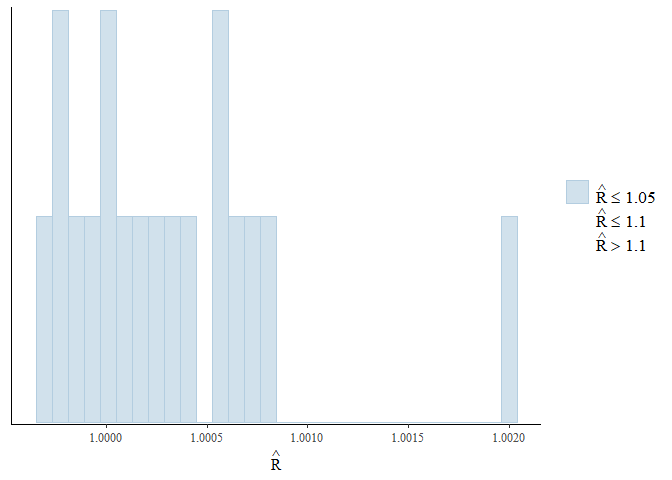

In [ ]:
mcmc_plot(mglmm_fit, plotfun = "rhat_hist")

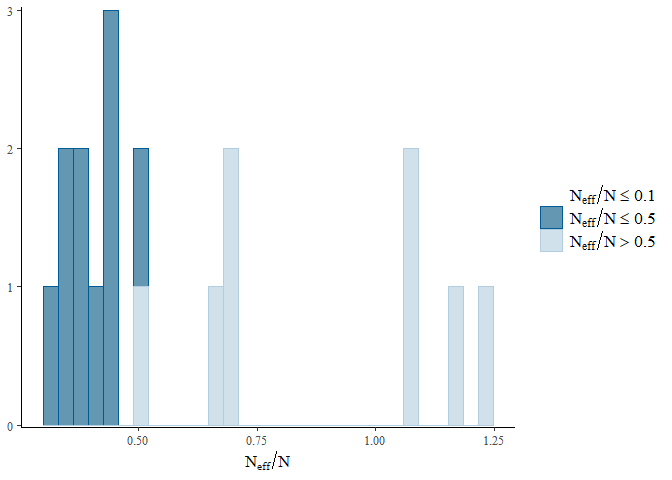

In [ ]:
mcmc_plot(mglmm_fit, plotfun = "neff_hist")

We can also examine the output for each parameter visually using a
traceplot combined with a density plot, which is given by the default
`plot()` command:

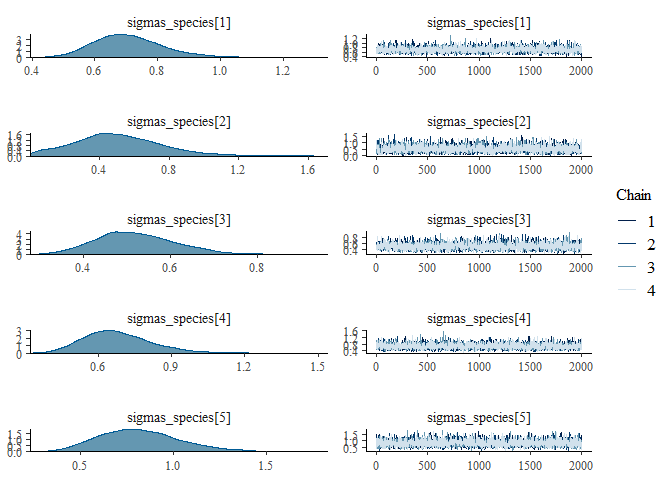

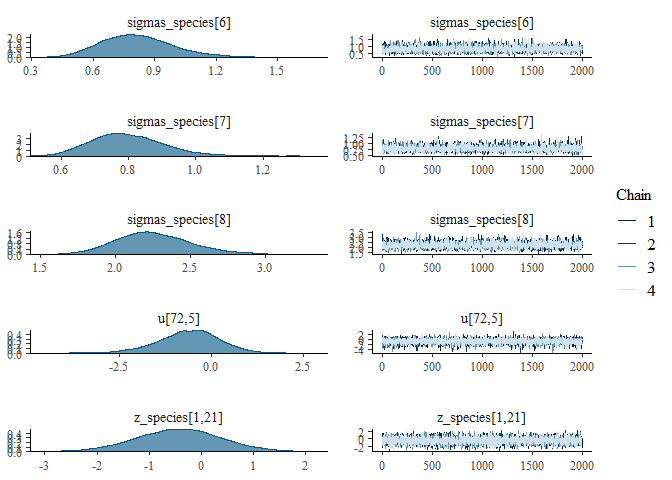

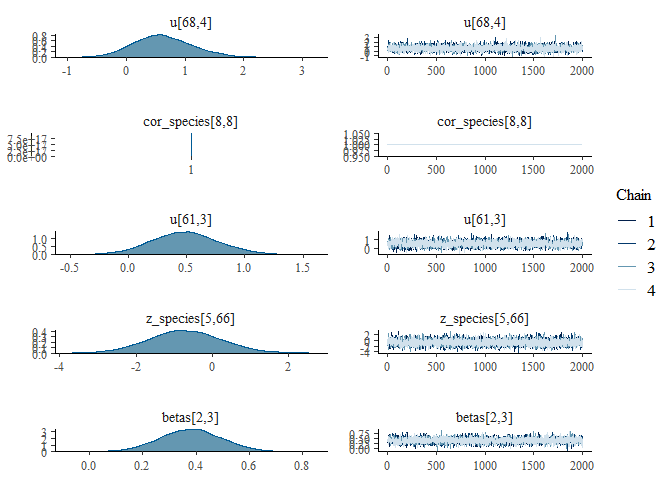

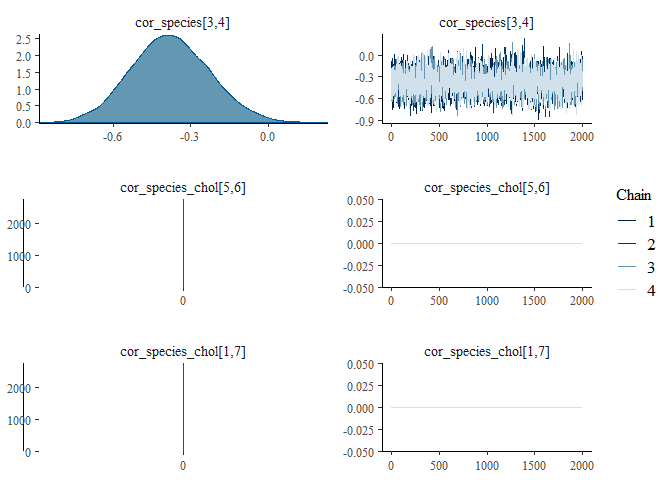

In [ ]:
plot(mglmm_fit, ask = FALSE)

By default the `plot()` command plots all of the parameters with sigma
or kappa in their name plus a random selection of 20 other parameters,
but this can be overridden by either specifying the parameters by name
(with or without regular expression matching) or changing the number of
parameters to be randomly sampled. Use the `get_parnames()` function to
get the names of parameters within a model - and the `jsdm_stancode()`
function can also be used to see the underlying structure of the model.

All the mcmc plot types within bayesplot are supported by the
`mcmc_plot()` function, and to see a full list either use
`bayesplot::available_mcmc()` or run `mcmc_plot()` with an incorrect
type and the options will be printed.

We can also view the environmental effect parameters for each species
using the `envplot()` function.

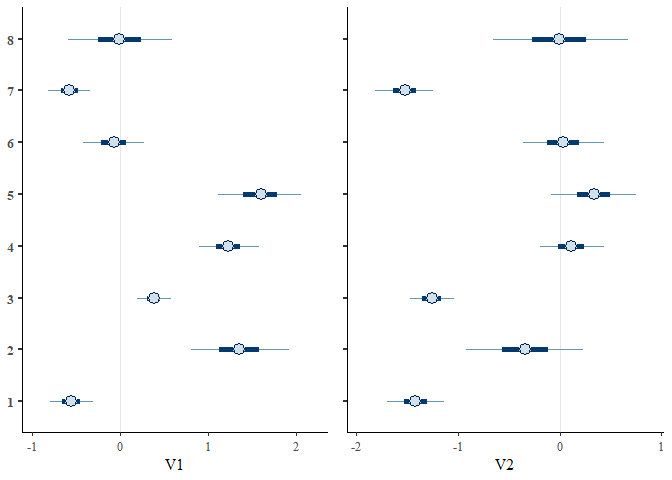

In [ ]:
envplot(mglmm_fit)

Posterior predictions can be extracted from the models using either
`posterior_linpred()` or `posterior_predict()`, where the linpred
function extracts the linear predictor for the community composition
within each draw and the predict function combines this linear predictor
extraction with a random generation based on the predicted probability
for the family. Both functions by default return a list of length equal
to the number of draws extracted, where each element of the list is a
sites by species matrix.

In [ ]:
mglmm_pp <- posterior_predict(mglmm_fit)
length(mglmm_pp)

[1] 8000

[1] 75  8

As well as the MCMC plotting functions within bayesplot the ppc\_ family
of functions is also supported through the `pp_check()` function. This
family of functions provides a graphical way to check your posterior
against the data used within the model to evaluate model fit - called a
posterior retrodictive check (or posterior predictive historically and
when the prior only has been sampled from). To use these you need to
have set `save_data = TRUE` within the `stan_jsdm()` call. Unlike in
other packages by default `pp_check()` for `jsdmStanFit` objects
extracts the posterior predictions then calculates summary statistics
over the rows and plots those summary statistics against the same for
the original data. The default behaviour is to calculate the sum of all
the species per site - i.e. total abundance.

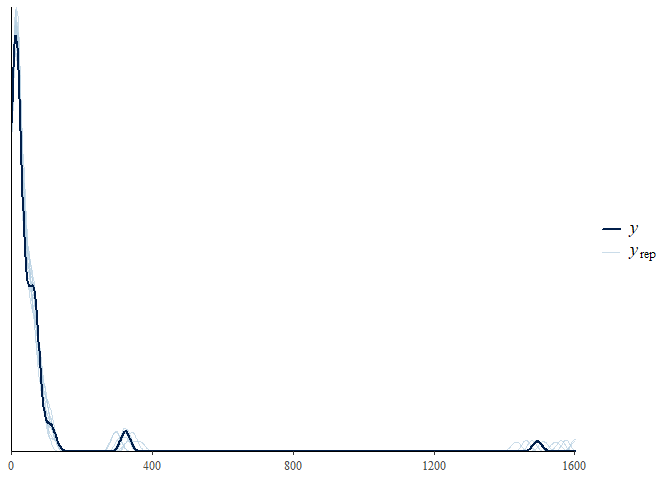

In [ ]:
pp_check(mglmm_fit)

The summary statistic can be changed, as can whether it is calculated
for every species or every site:

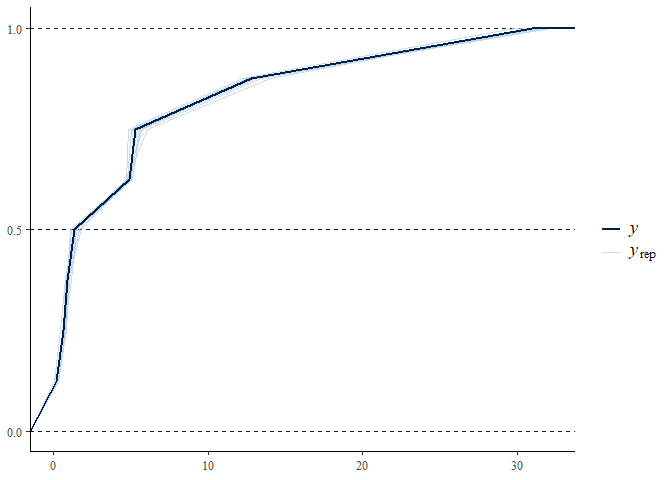

In [ ]:
pp_check(mglmm_fit, summary_stat = "mean", calc_over = "species",
         plotfun = "ecdf_overlay")

We can examine the species-specific posterior predictive check through
using `multi_pp_check()`, or examine how well the relationships between
specific species are recovered using `pp_check()` with
`plotfun = "pairs"`.

As we have run the above model on simulated data and the original data
list contains the parameters used to simulate the data we can use the
`mcmc_recover_` functions from `bayesplot` to see how the model did:

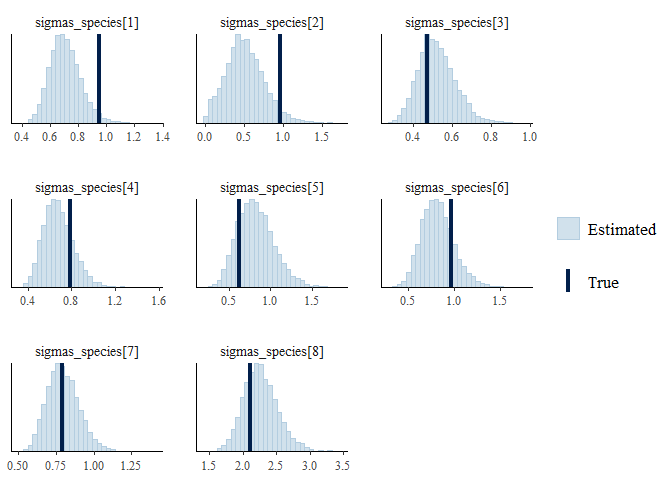

In [ ]:
mcmc_plot(mglmm_fit, plotfun = "recover_hist",
          pars = paste0("sigmas_species[",1:8,"]"),
          true = mglmm_test_data$pars$sigmas_species)

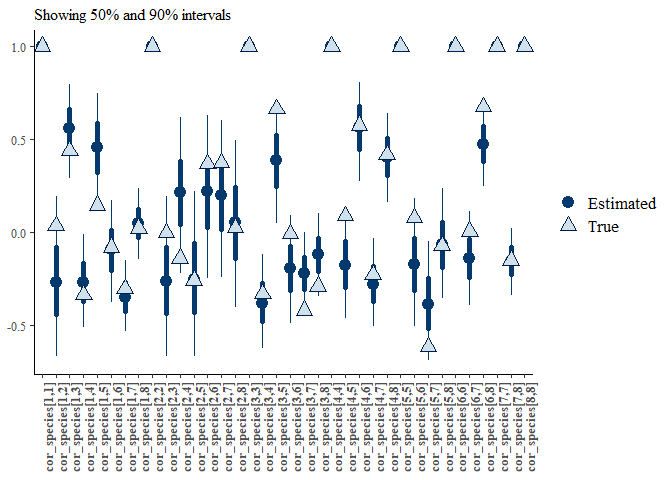

In [ ]:
mcmc_plot(mglmm_fit, plotfun = "recover_intervals",
          pars = paste0("cor_species[",rep(1:nspecies, nspecies:1),",",
                        unlist(sapply(1:8, ":",8)),"]"),
          true = c(mglmm_test_data$pars$cor_species[lower.tri(mglmm_test_data$pars$cor_species, diag = TRUE)])) +
  theme(axis.text.x = element_text(angle = 90))

## Fitting a GLLVM

The model fitting workflow for latent variable models is very similar to
that above, with the addition of specifying the number of latent
variables (D) in the data simulation and model fit. Here we change the
family to a Bernoulli family (i.e. the special case of the binomial
where the number of trials is 1 for all observations), make the
covariate effects on each species draw from a correlation matrix such
that information can be shared across species, and change the prior to
be a Student’s T prior on the predictor-specific sigma parameter.

In [ ]:
set.seed(3562251)
gllvm_data <- gllvm_sim_data(N = 50, S = 12, D = 2, K = 1,
                             family = "bernoulli",
                             beta_param = "cor",
                             prior = jsdm_prior(sigmas_preds = "student_t(3,0,1)"))

In [ ]:
gllvm_fit <- stan_jsdm(Y = gllvm_data$Y, X = gllvm_data$X,
                       D = gllvm_data$D,  
                       family = "bernoulli",
                       method = "gllvm", 
                       beta_param = "cor",
                       prior = jsdm_prior(sigmas_preds = "student_t(3,0,1)"),
                       refresh = 0)
gllvm_fit

Family: bernoulli 
 Model type: gllvm with 2 latent variables
  Number of species: 12
  Number of sites: 50
  Number of predictors: 2

Model run on 4 chains with 4000 iterations per chain (2000 warmup).

No parameters with Rhat > 1.01 or Neff/N < 0.05

Again, the diagnostic statistics seem reasonable:

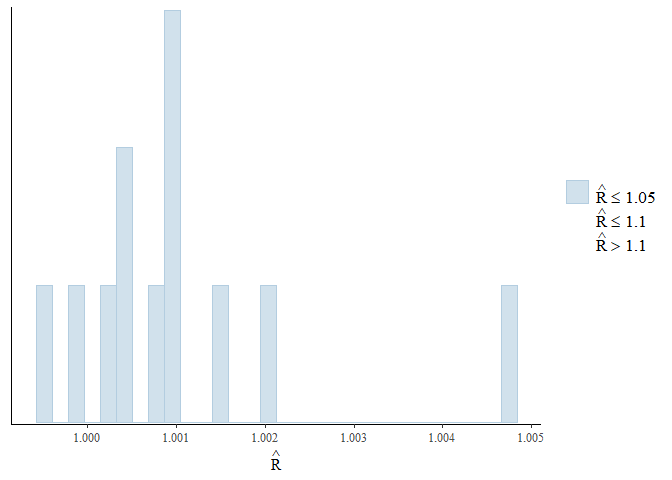

In [ ]:
mcmc_plot(gllvm_fit, plotfun = "rhat_hist")

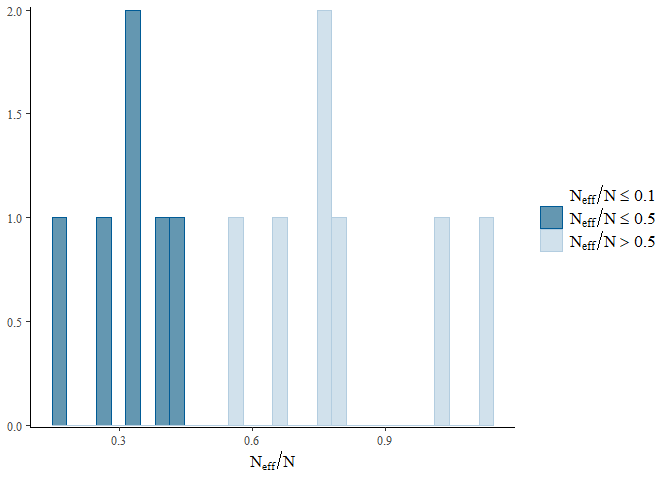

In [ ]:
mcmc_plot(gllvm_fit, plotfun = "neff_hist")

For brevity’s sake we will not go into the detail of the different
functions again here, however there is one plotting function
specifically for GLLVM models - `ordiplot()`. This plots the species or
sites scores against the latent variables from a random selection of
draws:

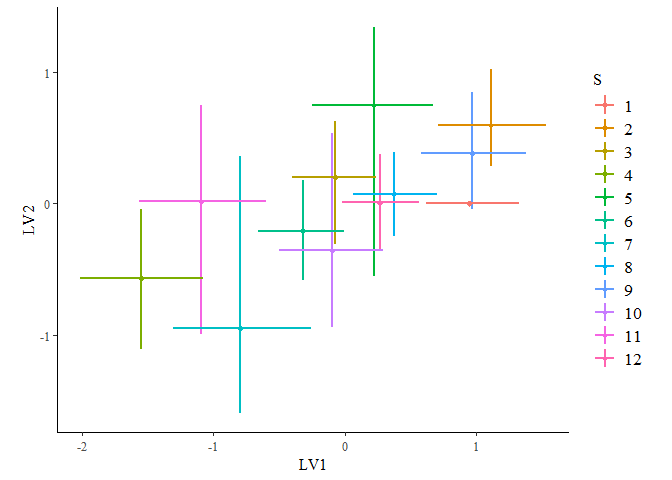

In [ ]:
ordiplot(gllvm_fit, errorbar_range = 0.5)

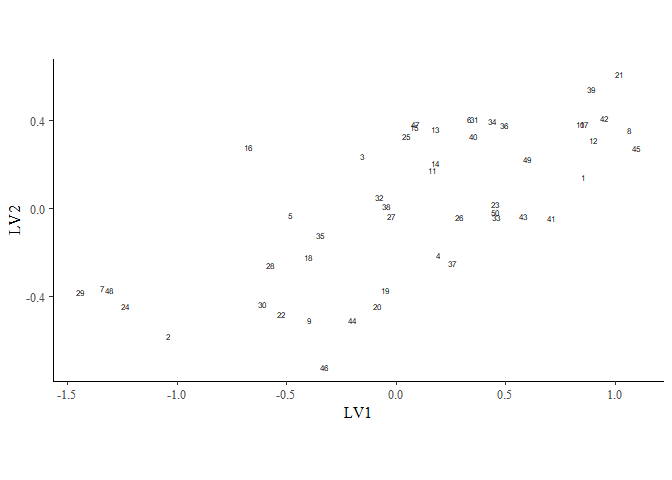

In [ ]:
ordiplot(gllvm_fit, type = "sites", geom = "text", errorbar_range = 0) +
  theme(legend.position = "none")

You can change the latent variables selected by specifying the `choices`
argument, and alter the number of draws or whether you want to plot
species or sites with the other arguments.

# Examples with Real Data

## MGLMM with broadleaved woodland survey data

We read in the bunce71 data from the jsdmstan package, giving a response
matrix of 45 tree genera over 103 sites and an environmental information
matrix that contains site location, number of plots per site as well as
five predictor variables - annual rainfall, maximum temperature in
summer, minimum temperature in winter, soil organic matter and soil pH.
We’re also changing the plotting theme, but that’s just to make the
following plots easier to parse and can be skipped if preferred.

In [ ]:
data("bunce71")
theme_set(bayesplot::theme_default() + 
            theme(panel.grid.major.y = element_line(colour = "grey92")))

We scale and centre the environmental predictor data - this is
particularly necessary as the rainfall data is centred around 1000. We
also sort the columns of the data frame of abundance, but this is purely
to make the graphs easier to read later on.

In [ ]:
bunce71_env <- mutate(bunce71$env, across(pH:WinterMinTemp, scale))
bunce71_abund <- bunce71$abund[,names(sort(colSums(bunce71$abund>0),
                                           decreasing = TRUE))]

We fit the model with unstructured environmental effects, default
priors, a binomial family distribution (Number of trials = number of
plots per site) and the default number of iterations.

In [ ]:
bwmod <- stan_mglmm(~Rainfall + SummerMaxTemp + WinterMinTemp + pH + SOM,
                    data = bunce71_env, Y = bunce71_abund, 
                    Ntrials = bunce71_env$Nplots, 
                    family = "binomial", 
                    cores = 4)

In [ ]:
bwmod

Family: binomial 
 Model type: mglmm
  Number of species: 45
  Number of sites: 103
  Number of predictors: 6

Model run on 4 chains with 4000 iterations per chain (2000 warmup).

Parameters with Rhat > 1.01, or Neff/N < 0.05:
                   mean sd 15% 85% Rhat Bulk.ESS Tail.ESS
cor_species[15,15]    1  0   1   1    1     8215     7647
cor_species[17,17]    1  0   1   1    1     7959     7566

No warnings are returned, the model has run acceptably with all Rhats \<
1.01 and effective sample sizes \> 500. Now we can evaluate fit to data,
first by looking at some summary statistics and then by looking at fit
for each individual species:

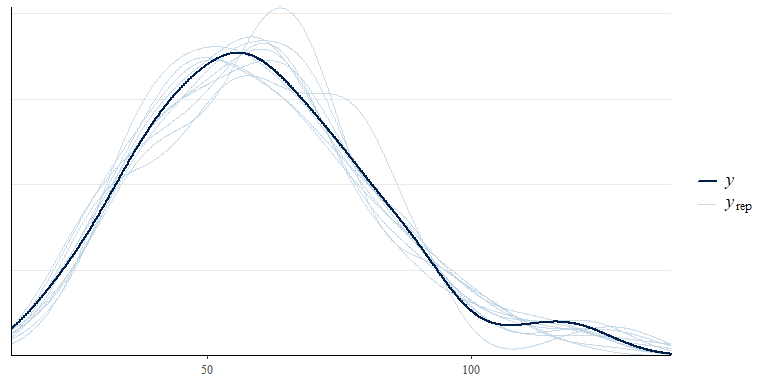

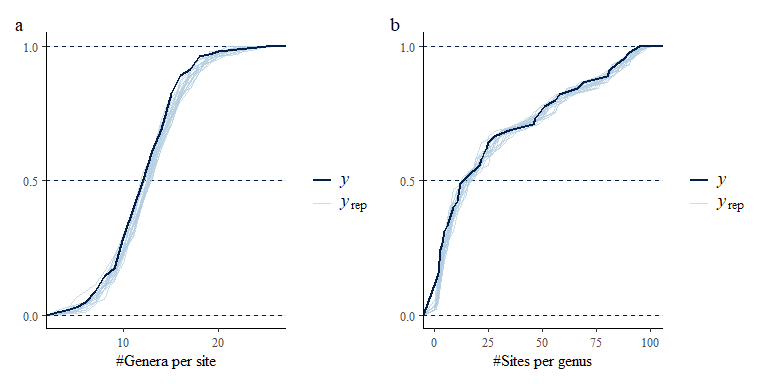

In [ ]:
pp_check(bwmod)

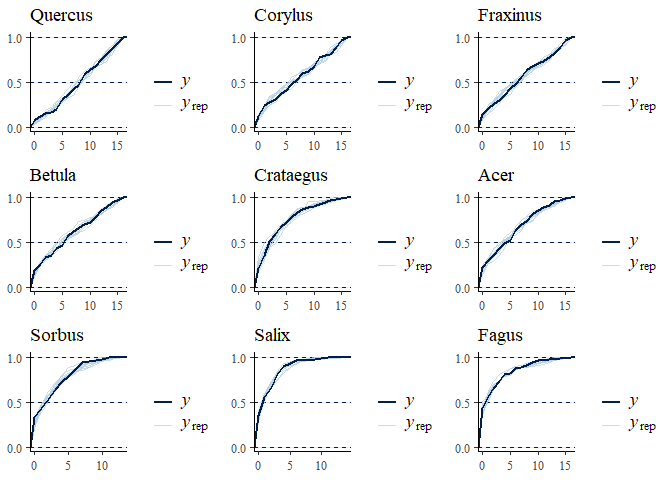

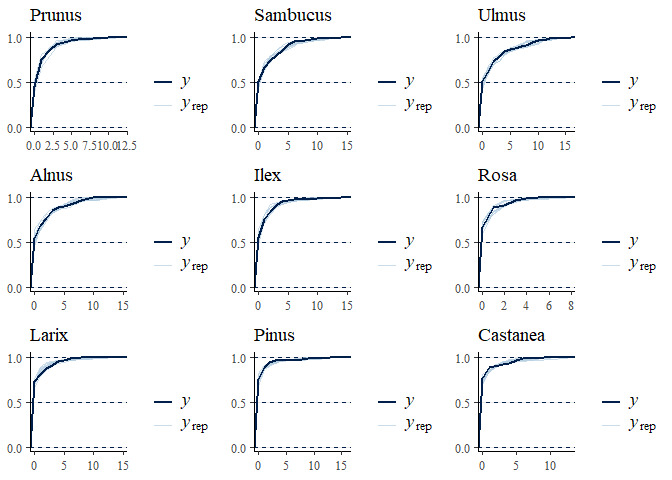

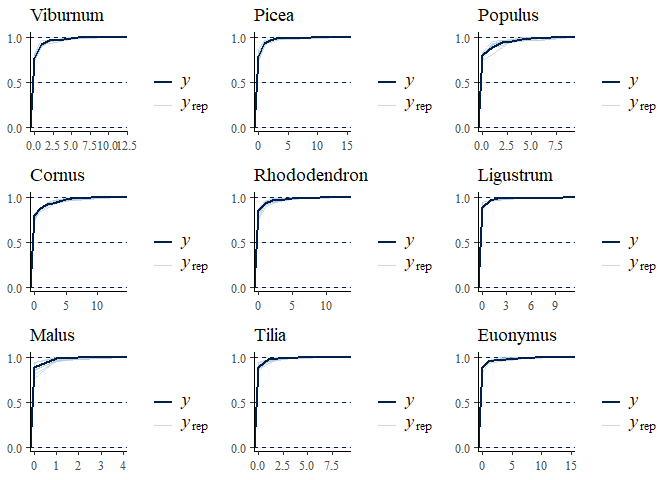

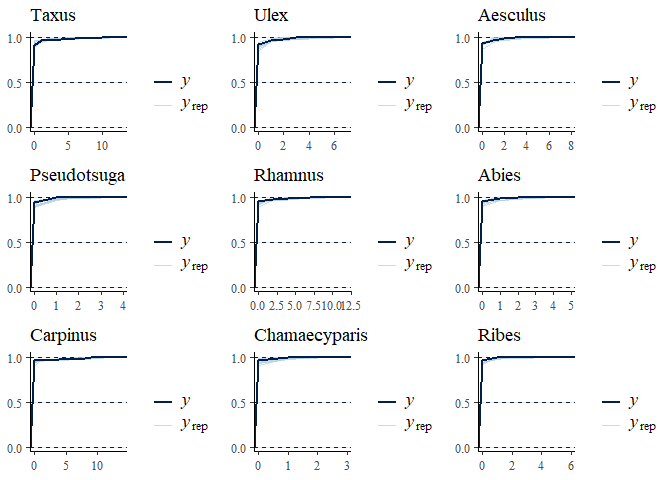

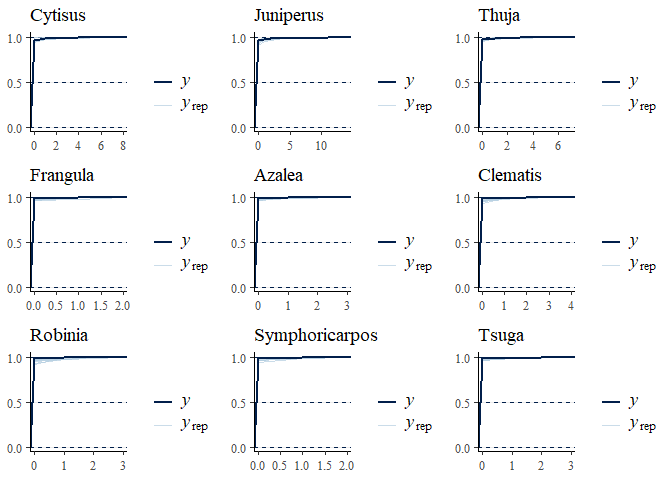

In [ ]:
multi_pp_check(bwmod, plotfun = "ecdf_overlay", species = 1:9)

We can now plot the environmental effects for each species:

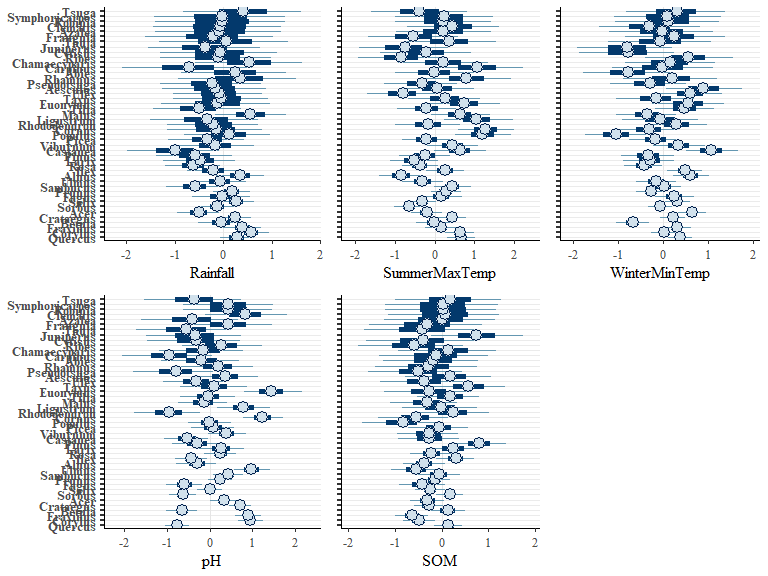

In [ ]:
envplot(bwmod, widths = c(1.5,1,1))

We can also plot the modelled correlations between species once this
environmental effect was accounted for:

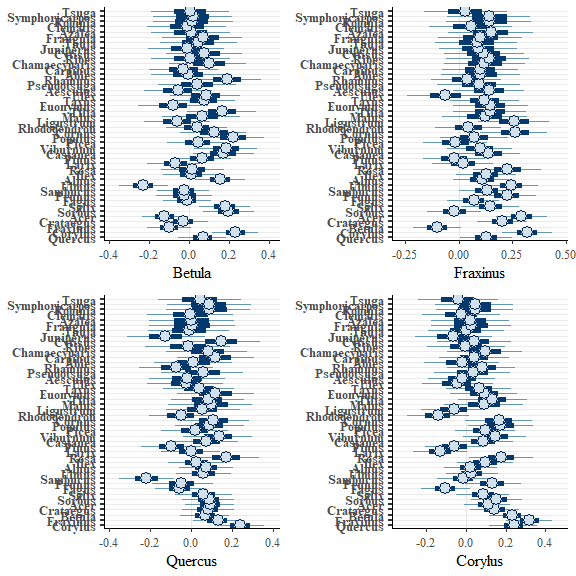

In [ ]:
corrplot(bwmod, species = c("Betula","Fraxinus","Quercus","Corylus"))

A subset of these plots are combined for the paper:

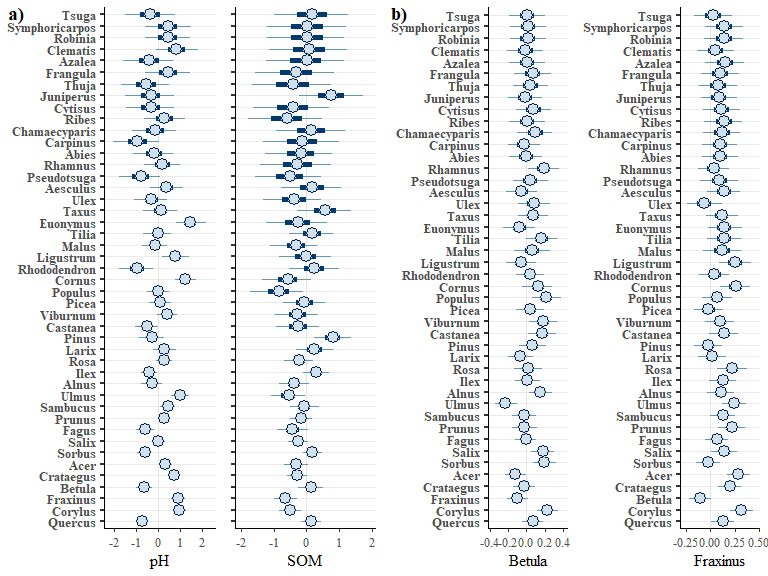

In [ ]:
e1 <- envplot(bwmod, widths = c(1.4,1), preds = c("pH","SOM"))
c1 <- corrplot(bwmod, species = c("Betula","Fraxinus"))
ggpubr::ggarrange(e1,c1, labels = c("a)","b)","c)","d)"))

## GLLVM with spider data

In [ ]:
theme_set(bayesplot::theme_default())

We use the spider data from the mvabund package to run a gllvm model
with two latent variables and a negative binomial response. All other
options are set to the default. Environmental predictors are scaled.

In [ ]:
data("spider", package = "mvabund")
spider$x <- scale(spider$x)

In [ ]:
spmod <- stan_gllvm(X = spider$x, Y = spider$abund, D = 2,
                    family = "neg", cores = 4)

In [ ]:
spmod

Family: neg_binomial 
 With parameters: kappa 
Model type: gllvm with 2 latent variables
  Number of species: 12
  Number of sites: 28
  Number of predictors: 7

Model run on 4 chains with 4000 iterations per chain (2000 warmup).

No parameters with Rhat > 1.01 or Neff/N < 0.05

No warnings are returned, the model has run acceptably with all Rhats \<
1.01 and effective sample sizes \> 500. Now we can evaluate fit to data,
first by looking at some summary statistics and then by looking at fit
for each individual species:

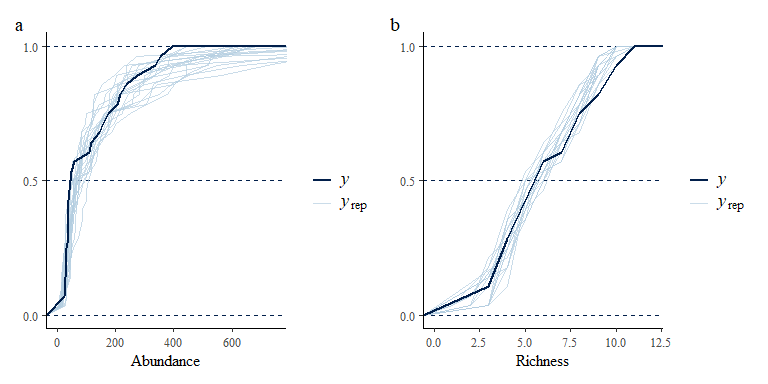

In [ ]:
p1 <- pp_check(spmod, plotfun = "ecdf_overlay", ndraws = 20) +
  labs(x = "Abundance") +
  coord_cartesian(xlim = c(0,750))
p2 <- pp_check(spmod,  plotfun = "ecdf_overlay", 
         summary_stat = function(x) sum(x>0), ndraws = 20) + 
  labs(x = "Richness")+
  coord_cartesian(xlim = c(0,12))
p1 + p2 + plot_annotation(tag_levels = "a")

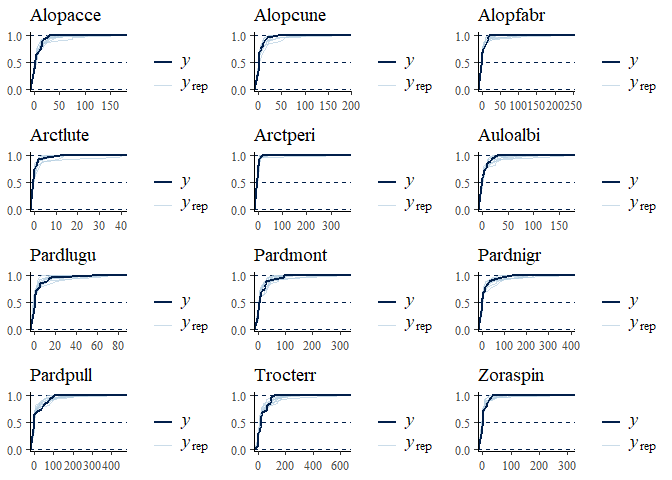

In [ ]:
multi_pp_check(spmod, plotfun = "ecdf_overlay")

We can now plot the environmental effects for each species:

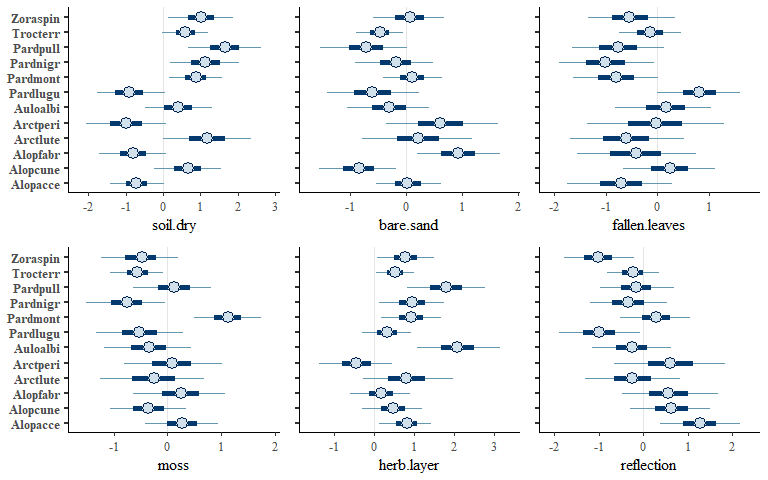

In [ ]:
envplot(spmod, widths = c(1.2,1,1))

We can also plot latent variable loadings for the species and sites:

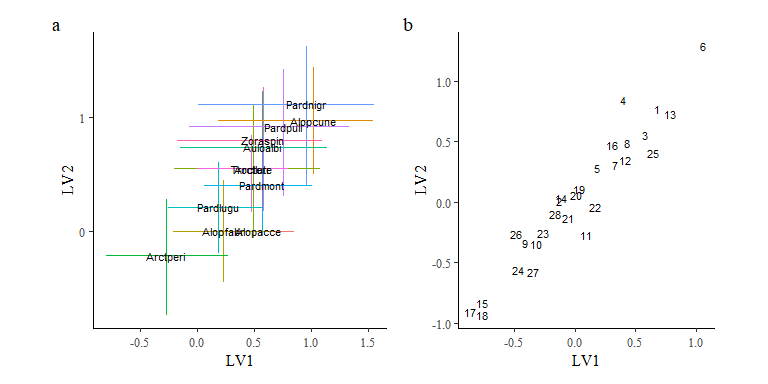

In [ ]:
o1 <- ordiplot(spmod, ndraws = 0, geom = "text", size = c(3,1),
               errorbar_linewidth = 0.5, errorbar_range = 0.5) + 
  theme(legend.position = "none") 
o2 <- ordiplot(spmod, ndraws = 0, geom = "text", type = "sites", size = c(3,1), 
               errorbar_range = NULL)
o1 + o2 + plot_annotation(tag_levels = "a")

Note that while the model fits the data well, the estimates for the
latent variable loadings indicate that the model are trending towards a
linear fit with each other indicating the model does not have sufficient
information to estimate these latent variables on top of the six
environmental predictors. Therefore, we shall fit a reduced model with
fewer environmental predictors included.

In [ ]:
spmod2 <- update(spmod, newX = spider$x[,c("soil.dry","herb.layer")],
                 cores = 4)

In [ ]:
spmod2

Family: neg_binomial 
 With parameters: kappa 
Model type: gllvm with 2 latent variables
  Number of species: 12
  Number of sites: 28
  Number of predictors: 3

Model run on 4 chains with 4000 iterations per chain (2000 warmup).

No parameters with Rhat > 1.01 or Neff/N < 0.05

No warnings are returned, the model has run acceptably with all Rhats \<
1.01 and effective sample sizes \> 500. Now we can evaluate fit to data,
first by looking at some summary statistics and then by looking at fit
for each individual species:

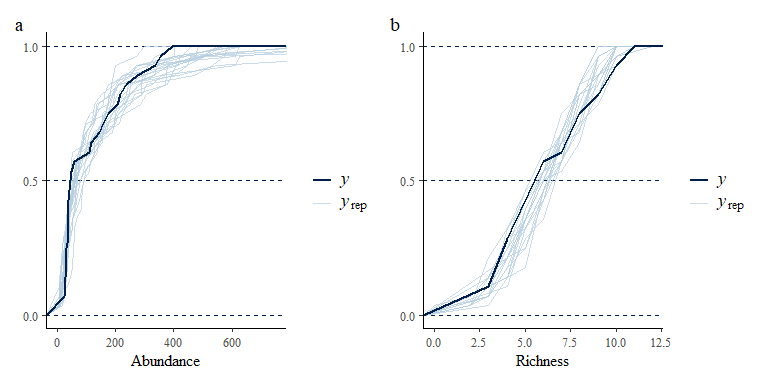

In [ ]:
p1b <- pp_check(spmod2, plotfun = "ecdf_overlay", ndraws = 20) +
  labs(x = "Abundance") +
  coord_cartesian(xlim = c(0,750))
p2b <- pp_check(spmod2,  plotfun = "ecdf_overlay", 
         summary_stat = function(x) sum(x>0), ndraws = 20) + 
  labs(x = "Richness")+
  coord_cartesian(xlim = c(0,12))
p1b + p2b + plot_annotation(tag_levels = "a")

We combine (some of) the posterior predictive check plots for the two
models for the paper:

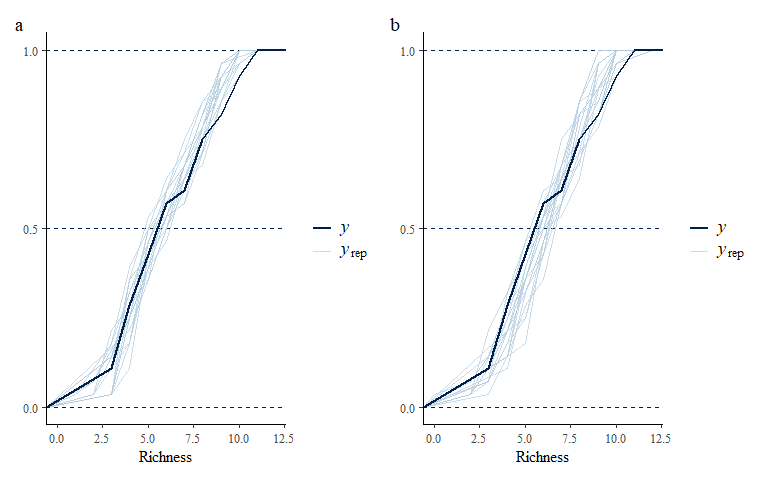

In [ ]:
p2 + p2b + plot_annotation(tag_levels = "a")

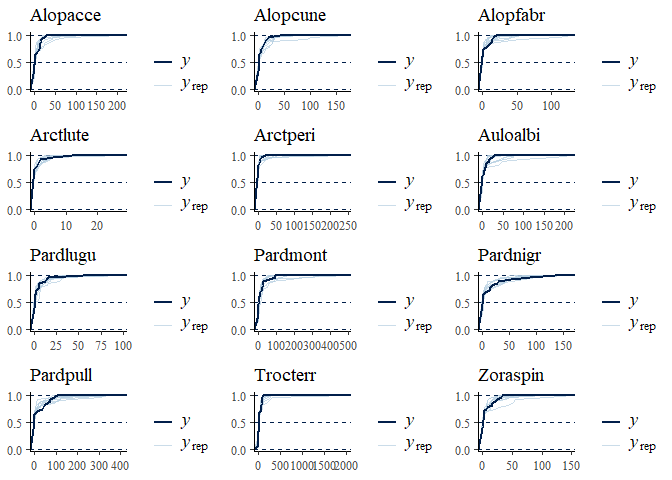

In [ ]:
multi_pp_check(spmod2, plotfun = "ecdf_overlay")

We can also plot the environmental effects for each species:

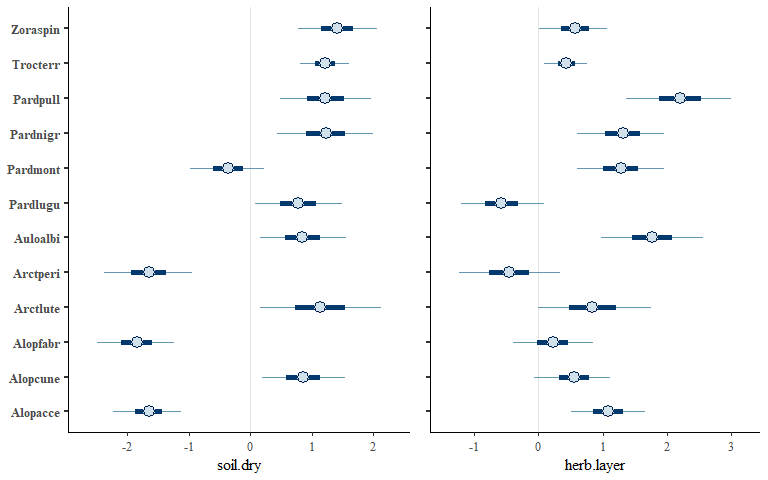

In [ ]:
envplot(spmod2, widths = c(1.2,1))

We can also plot latent variable loadings for the species and sites:

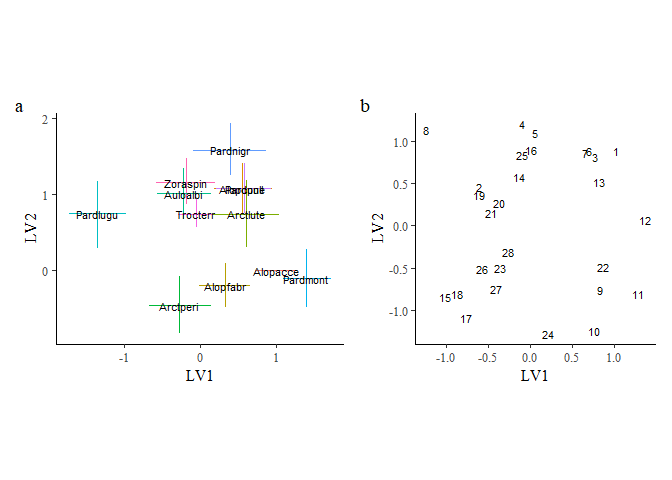

In [ ]:
o1v2 <- ordiplot(spmod2, ndraws = 0, geom = "text", size = c(3,1),
                 errorbar_linewidth = 0.5, errorbar_range = 0.5) + 
  theme(legend.position = "none")
o2v2 <- ordiplot(spmod2, ndraws = 0, geom = "text", type = "sites", size = c(3,1), 
                 errorbar_range = NULL)
o1v2 + o2v2 + plot_annotation(tag_levels = "a")

Comparing the latent variable plots for the two models shows clearly
that the reduced model loses the linear trend in latent variable
loadings.

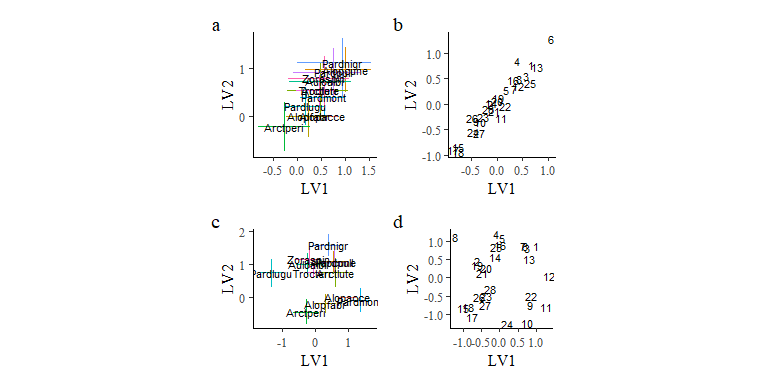

In [ ]:
o1 + o2 + o1v2 + o2v2 + plot_annotation(tag_levels = "a")

# References

Warton et al (2015) So many variables: joint modeling in community
ecology. Trends in Ecology & Evolution, 30:766-779. DOI:
[10.1016/j.tree.2015.09.007](http:://doi.org/10.1016/j.tree.2015.09.007).

Wilkinson et al (2021) Defining and evaluating predictions of joint
species distribution models. Methods in Ecology and Evolution,
12:394-404. DOI:
[10.1111/2041-210X.13518](http:://doi.org/10.1111/2041-210X.13518).

Vehtari, A., Gelman, A., and Gabry, J. (2017). Practical Bayesian model
evaluation using leave-one-out cross-validation and WAIC. Statistics and
Computing. 27(5), 1413–1432. DOI:
[10.1007/s11222-016-9696-4](http::doi.org/10.1007/s11222-016-9696-4).
